# Seperating stock to forcast for certain dates depending on the product

In [19]:
%pip install nbformat pandas numpy matplotlib seaborn scikit-learn xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [21]:
import sys
sys.path.append('../../src')

In [22]:
from data_config import ProductHandler as ph

In [23]:
ph.custom_prod_set()

All custom codes for existing products: 
{'SVO', 'FLA', '607', '037', '18Y', '669', 'AMS', '696', '858', '042', '54Z', 'L-D', '335', '247', 'OU-', '457', '731', '69X', '664', '97Y', 'AFS', '990', 'ML1', '662', 'D-0', '80X', '88V', 'Y-4', '63T', '957', '147', '21U', '366', '-F2', '04W', '64X', 'O-T', 'CW-', '85X', 'TR-', '77X', '-01', '076', '57V', '136', 'ZIN', 'MAS', 'BEB', 'HSP', '170', '822', '92Z', '04R', '50W', '72X', '30U', 'OSM', '985', 'PLA', 'SHO', '491', '43X', 'WEX', '30Z', '656', 'TRO', '069', '949', '47Z', '395', '332', '364', '130', '07T', '53Y', '832', '826', '212', '71U', '271', '161', '34S', 'OF-', '014', '13U', 'ARO', '268', '244', '412', '649', '783', 'SPW', '222', 'OS-', '106', '710', '45S', '938', 'EA-', '484', '74X', '939', 'RS-', 'PER', 'ORE', 'PPJ', '63S', '564', '533', '137', '01V', '14X', '56X', 'WEI', '51Y', '1Z-', '6-1', '56Y', '90Y', '20-', '71Z', '223', '37W', '902', '72Y', 'MI-', '00V', '03R', '183', '45X', '765', '38S', '506', 'AD-', '377', '950', '494',

In [24]:
# # display the highest order quantity customers 
# ph.highest_customs()

In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# define the features and target variable from 'product_sales'
# CHANGE THE CUSTOMER CODE HERE >>>>>>>>>>
custom_code_df = pd.DataFrame(ph.get_custom_code_data('UND'))

# customer code for later referencing
custom_ref = custom_code_df.loc[0, 'ProductNumber'][:3].lower().upper()
print(custom_ref)

custom_code_df.head()

UND


,ProductNumber,order_year,order_month,order_week,order_weekday,is_weekend,Customer_Num,OrderQuantity,prev_month_sales,prev_week_sales,...,moving_avg_3m,moving_avg_6m,moving_avg_12m,moving_avg_18m,sales_2022,sales_2023,sales_2024,growth_2023,growth_2024,PhysicalInv
0,UND-026-0002Y,2022,1,4,2,0,194.0,30000,40000.00000,40000.00000,...,37333.333333,37000.000000,37000.000000,37000.000000,30000,0,0,-100.0,NaN,0
1,UND-026-0002Y,2022,3,12,1,0,194.0,40000,42000.00000,42000.00000,...,39333.333333,39333.333333,39333.333333,39333.333333,40000,0,0,-100.0,NaN,0
2,UND-026-0002Y,2022,6,23,4,0,194.0,42000,36000.00000,36000.00000,...,39000.000000,39000.000000,39000.000000,39000.000000,42000,0,0,-100.0,NaN,0
3,UND-026-0002Y,2024,7,28,2,0,194.0,36000,110031.53337,110031.53337,...,36000.000000,36000.000000,36000.000000,36000.000000,0,0,36000,NaN,inf,0
4,UND-026-0003Y,2022,3,12,1,0,194.0,10000,10000.00000,10000.00000,...,11333.333333,12666.666667,12666.666667,12666.666667,10000,0,0,-100.0,NaN,0


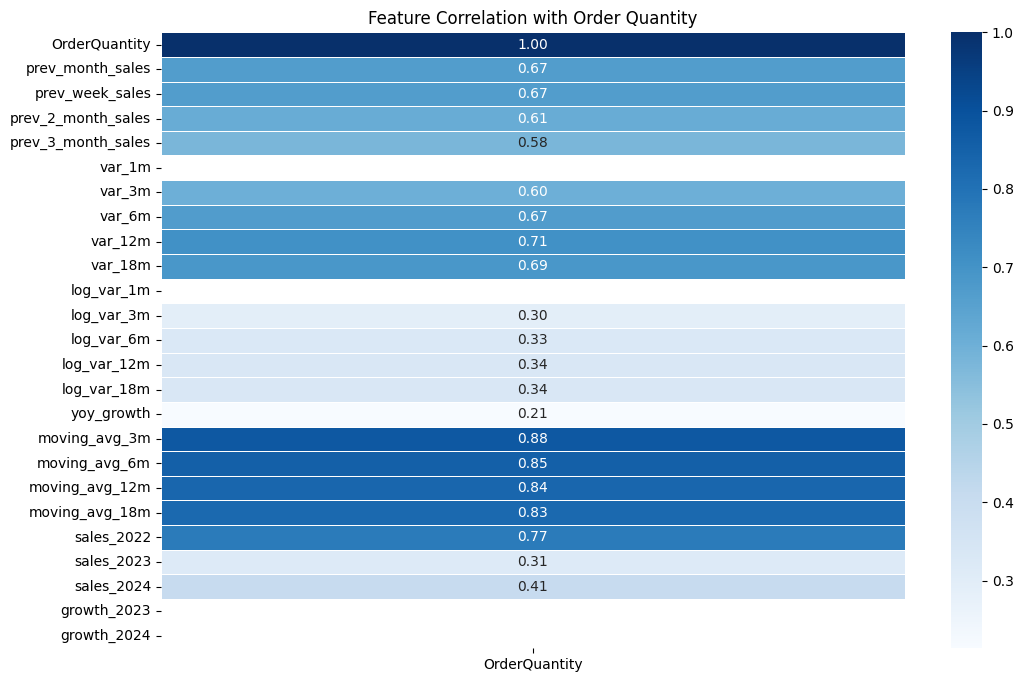

In [26]:
ph.feature_importance(custom_code_df)

In [27]:
from scipy import stats

# Define a function to compute z-scores within each product group
def compute_zscore(group, threshold=3):
    # Only compute z-score if there are at least 2 data points in the group
    if len(group) >= 2:
        group['z_score'] = np.abs(stats.zscore(group['OrderQuantity']))
    else:
        group['z_score'] = 0  # or np.nan if preferred
    return group

# Group by "ProductNumber" and compute z-scores for "OrderQuantity" within each group
df_grouped = custom_code_df.groupby('ProductNumber').apply(compute_zscore)

# Define your threshold for what constitutes an "unusually high" order
z_threshold = 3

# Filter for outliers (orders with a z_score greater than the threshold)
df_outliers = df_grouped[df_grouped['z_score'] > z_threshold]

# Display the results
print("Unusually high order quantities (per ProductNumber):")
print(df_outliers[['ProductNumber', 'OrderQuantity', 'z_score']])

print(f'Dropping: \n{df_outliers.count()}')
# Keep only rows where the z-score is within the acceptable range
df_cleaned = df_grouped[df_grouped['z_score'] <= z_threshold].drop(columns=['z_score'])

# Reset index for clarity
df_cleaned.reset_index(drop=True, inplace=True)

custom_code_df = df_cleaned


Unusually high order quantities (per ProductNumber):
                    ProductNumber  OrderQuantity   z_score
ProductNumber                                             
UND-026-0008Z 49    UND-026-0008Z         320000  3.890424
              3689  UND-026-0008Z         320000  3.890424
UND-026-0012Z 191   UND-026-0012Z        2224000  3.164748
              3831  UND-026-0012Z        2224000  3.164748
UND-026-0015Z 324   UND-026-0015Z         380000  3.186842
...                           ...            ...       ...
UND-026-0211Z 7165  UND-026-0211Z           8000  3.188889
UND-026-0218Z 3560  UND-026-0218Z         245000  3.314069
              7200  UND-026-0218Z         245000  3.314069
UND-026-0219Z 3574  UND-026-0219Z          90000  3.474632
              7214  UND-026-0219Z          90000  3.474632

[90 rows x 3 columns]
Dropping: 
ProductNumber         90
order_year            90
order_month           90
order_week            90
order_weekday         90
is_weekend           

C:\Users\44777\AppData\Local\Temp\ipykernel_15232\1363007664.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  group['z_score'] = np.abs(stats.zscore(group['OrderQuantity']))
C:\Users\44777\AppData\Local\Temp\ipykernel_15232\1363007664.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  group['z_score'] = np.abs(stats.zscore(group['OrderQuantity']))
C:\Users\44777\AppData\Local\Temp\ipykernel_15232\1363007664.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  group['z_score'] = np.abs(stats.zscore(group['OrderQuantity']))
C:\Users\44777\AppData\Local\Temp\ipykernel_15232\1363007664.py:7: RuntimeWarning: Preci

In [28]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
df = custom_code_df

features = ['ProductNumber', 'order_month',
            'prev_month_sales', 'prev_week_sales', 'prev_2_month_sales', 'prev_3_month_sales',
            'moving_avg_3m', 'moving_avg_6m', 'moving_avg_12m', 'moving_avg_18m',
            'var_3m', 'var_6m', 'var_12m', 'var_18m',
            'log_var_3m', 'log_var_6m', 'log_var_12m', 'log_var_18m',
            'yoy_growth', 'sales_2023', 'sales_2024'
            ]
target = 'OrderQuantity'

X = df[features]
y = df[target]

# one-hot encoding for categorical features
categorical_features = ['ProductNumber']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# preprocessor (keeps numerical features as is)
preprocessor = ColumnTransformer(
    transformers=[
        # one-hot encode categorical features
        ('cat', encoder, categorical_features)
    ], remainder='passthrough'
)

# transform the features
X_transformed = preprocessor.fit_transform(X)


In [29]:
# all products order quants for defined customer list (2022-2025)
X_train, X_val, y_train, y_val = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [30]:
customer_total = df.copy()

# define features and target
features = ['ProductNumber', 'order_month', 'order_week', 'order_weekday',
            'prev_month_sales', 'prev_week_sales', 'prev_2_month_sales', 'prev_3_month_sales',
            'moving_avg_3m', 'moving_avg_6m', 'moving_avg_12m', 'moving_avg_18m',
            'var_3m', 'var_6m', 'var_12m', 'var_18m',
            'log_var_3m', 'log_var_6m', 'log_var_12m', 'log_var_18m',
            'yoy_growth', 'sales_2023', 'sales_2024'
           ]
target = 'OrderQuantity'

# filter the top products
total_X = customer_total[features]  # Features from top products
total_y = customer_total[target]    # Target variable

# define categorical and numeric features
categorical_features = ['ProductNumber']
numeric_features = list(set(features) - set(categorical_features))  # All other features are numeric

# Define transformations
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()

# ColumnTransformer to apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', encoder, categorical_features),   # One-hot encode categorical features
        ('num', scaler, numeric_features)        # Standardize numeric features
    ]
)

# Train-test split
total_X_train, total_X_val, total_y_train, total_y_val = train_test_split(total_X, total_y, test_size=0.2, random_state=42)

# Transform the features
total_X_train_transformed = preprocessor.fit_transform(total_X_train)
total_X_val_transformed = preprocessor.transform(total_X_val)

# Output the shape
print(f"Train Shape: {total_X_train_transformed.shape}, Validation Shape: {total_X_val_transformed.shape}")
print("Feature processing for top products completed successfully!")

customer_total.head()


Train Shape: (5574, 235), Validation Shape: (1394, 235)
Feature processing for top products completed successfully!


,ProductNumber,order_year,order_month,order_week,order_weekday,is_weekend,Customer_Num,OrderQuantity,prev_month_sales,prev_week_sales,...,moving_avg_3m,moving_avg_6m,moving_avg_12m,moving_avg_18m,sales_2022,sales_2023,sales_2024,growth_2023,growth_2024,PhysicalInv
0,UND-026-0002Y,2022,1,4,2,0,194.0,30000,40000.00000,40000.00000,...,37333.333333,37000.000000,37000.000000,37000.000000,30000,0,0,-100.0,NaN,0
1,UND-026-0002Y,2022,3,12,1,0,194.0,40000,42000.00000,42000.00000,...,39333.333333,39333.333333,39333.333333,39333.333333,40000,0,0,-100.0,NaN,0
2,UND-026-0002Y,2022,6,23,4,0,194.0,42000,36000.00000,36000.00000,...,39000.000000,39000.000000,39000.000000,39000.000000,42000,0,0,-100.0,NaN,0
3,UND-026-0002Y,2024,7,28,2,0,194.0,36000,110031.53337,110031.53337,...,36000.000000,36000.000000,36000.000000,36000.000000,0,0,36000,NaN,inf,0
4,UND-026-0002Y,2022,1,4,2,0,194.0,30000,40000.00000,40000.00000,...,37333.333333,37000.000000,37000.000000,37000.000000,30000,0,0,-100.0,NaN,0


In [31]:
# the top 10 (or change) products by total actual order quantity
top_products = df.groupby('ProductNumber')['OrderQuantity'].sum().nlargest(1)

# extract top product code rows from the original df
top_prods_df = df[df['ProductNumber'].isin(top_products.index)]

# Extract top product numbers
top_product_numbers = top_products.index.tolist()  # List of top product numbers

top_prods_df.head()

unique_order_years = custom_code_df['order_year'].unique()
print(unique_order_years)

[2022 2024 2023 2021 2025]


In [32]:
# define features and target
features = ['ProductNumber', 'order_month', 
            'prev_month_sales', 'prev_week_sales', 'prev_2_month_sales', 'prev_3_month_sales',
            'moving_avg_3m', 'moving_avg_6m', 'moving_avg_12m', 'moving_avg_18m',
            'var_3m', 'var_6m', 'var_12m', 'var_18m',
            'log_var_3m', 'log_var_6m', 'log_var_12m', 'log_var_18m',
            'yoy_growth', 'sales_2023', 'sales_2024'
           ]
target = 'OrderQuantity'

# filter the top products
tp_X = top_prods_df[features]  # Features from top products
tp_y = top_prods_df[target]    # Target variable

# define categorical and numeric features
categorical_features = ['ProductNumber']
numeric_features = list(set(features) - set(categorical_features))  # All other features are numeric

# Define transformations
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()

# ColumnTransformer to apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', encoder, categorical_features),   # One-hot encode categorical features
        ('num', scaler, numeric_features)        # Standardize numeric features
    ]
)

# Train-test split
tp_X_train, tp_X_val, tp_y_train, tp_y_val = train_test_split(tp_X, tp_y, test_size=0.2, random_state=42)

# Transform the features
tp_X_train_transformed = preprocessor.fit_transform(tp_X_train)
tp_X_val_transformed = preprocessor.transform(tp_X_val)

# Output the shape
print(f"Train Shape: {tp_X_train_transformed.shape}, Validation Shape: {tp_X_val_transformed.shape}")
print("Feature processing for top products completed successfully!")


Train Shape: (49, 21), Validation Shape: (13, 21)
Feature processing for top products completed successfully!


In [33]:
from sklearn.ensemble import RandomForestRegressor
from model_utils import *

In [34]:
# train the model with scaled features (Random Forest Regressor)
rf = RandomForestRegressor()
rf_params = find_best_hyperparameters(rf, param_grids(rf.__class__.__name__), X_train_scaled, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
RandomForestRegressor Best Parameters: {'criterion': 'squared_error', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [35]:
rf = RandomForestRegressor(**rf_params)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_val_scaled)

In [36]:
print('---------------------- TRAINING PERFORMANCE ----------------------')
evaluate_model(rf, X_train_scaled, y_train, 'TRAINING')
print('--------------------------------------------')

print('---------------------- TEST PERFORMANCE ----------------------')
evaluate_model(rf, X_val_scaled, y_val, 'TEST')
print('--------------------------------------------')

---------------------- TRAINING PERFORMANCE ----------------------

TRAINING PERFORMANCE:
MAE: 6377.1948
MSE: 1307969246.9493
RMSE: 36165.8575
R²: 0.9874
---------------------------------------------
--------------------------------------------
---------------------- TEST PERFORMANCE ----------------------

TEST PERFORMANCE:
MAE: 15321.3857
MSE: 4526103311.2799
RMSE: 67276.3206
R²: 0.9699
---------------------------------------------
--------------------------------------------


In [37]:
# train the model with scaled features (Random Forest Regressor) - TOTAL CUSTOM PRODUCTS IMPLEMENTATION
total_rf = RandomForestRegressor()
total_rf_params = find_best_hyperparameters(total_rf, param_grids(total_rf.__class__.__name__), total_X_train_transformed, total_y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
RandomForestRegressor Best Parameters: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [38]:
total_rf = RandomForestRegressor(**total_rf_params)
total_rf.fit(total_X_train_transformed, total_y_train)
total_y_pred_rf = total_rf.predict(total_X_val_transformed)

In [39]:
print('---------------------- TRAINING PERFORMANCE ----------------------')
evaluate_model(total_rf, total_X_train_transformed, total_y_train, 'TRAINING')
print('--------------------------------------------')

print('---------------------- TEST PERFORMANCE ----------------------')
evaluate_model(total_rf, total_X_val_transformed, total_y_val, 'TEST')
print('--------------------------------------------')

---------------------- TRAINING PERFORMANCE ----------------------

TRAINING PERFORMANCE:
MAE: 13799.1003
MSE: 1704749883.3665
RMSE: 41288.6169
R²: 0.9836
---------------------------------------------
--------------------------------------------
---------------------- TEST PERFORMANCE ----------------------

TEST PERFORMANCE:
MAE: 20606.7300
MSE: 5373119258.4251
RMSE: 73301.5638
R²: 0.9643
---------------------------------------------
--------------------------------------------


[3064800.0, 7720.0, 74270.58823529411, 42033.213211862014, 19988.062573196203, 64402.86363636363, 18448.076440746536, 332240.0, 109800.0, 12505.263157894737, 40083.90224365963, 35850.482662780574, 20059.147530697355, 142310.0, 9572.477477477478, 1274820.0, 13956.654128822322, 14529.523809523811, 32015.720121301307, 411600.0, 80840.0, 36137.34860893342, 68484.61538461538, 32431.89826839827, 60320.0, 59200.0, 19994.766483810723, 20945.38509170787, 19019.213649096, 23581.399833511292, 24000.0, 142080.0, 24000.0, 18382.76923076923, 588480.0, 25673.83980818334, 136838.15118215117, 34974.714924941356, 797200.0, 18607.246223452345, 180645.93406593404, 63878.730158730155, 48200.0, 39680.0, 18894.65404552626, 171953.3333333333, 82656.0, 55050.217391304344, 42960.0, 20718.38859863905, 31991.637826961767, 151324.99194847018, 156720.0, 74653.125, 199640.0, 21349.351311537455, 63235.83333333333, 19962.5204045215, 45175.873015873025, 19985.892358713332, 35841.08718630167, 21081.0368815179, 19997.271

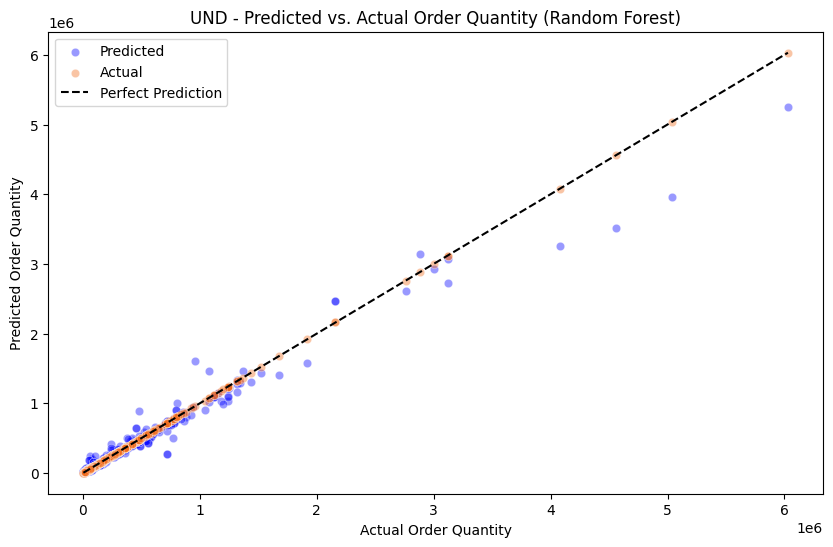

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

print(y_pred_rf.tolist())

plt.figure(figsize=(10, 6))

# scatter plot, actual vs predicted values
sns.scatterplot(x=y_val, y=y_pred_rf, alpha=0.4, color='blue', label='Predicted')  # Predicted values in blue

# actual values in red
sns.scatterplot(x=y_val, y=y_val, alpha=0.4, color='#f26d1d', label='Actual')

# reference line for perfect prediction
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color='black', label="Perfect Prediction")

plt.xlabel("Actual Order Quantity")
plt.ylabel("Predicted Order Quantity")
plt.title(f"{custom_ref} - Predicted vs. Actual Order Quantity (Random Forest)")
plt.legend()

plt.show()

C:\Users\44777\AppData\Local\Temp\ipykernel_15232\1606837329.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_prods_df['OrderDate'] = pd.to_datetime(top_prods_df[['order_year', 'order_month']].astype(str).agg('-'.join, axis=1))


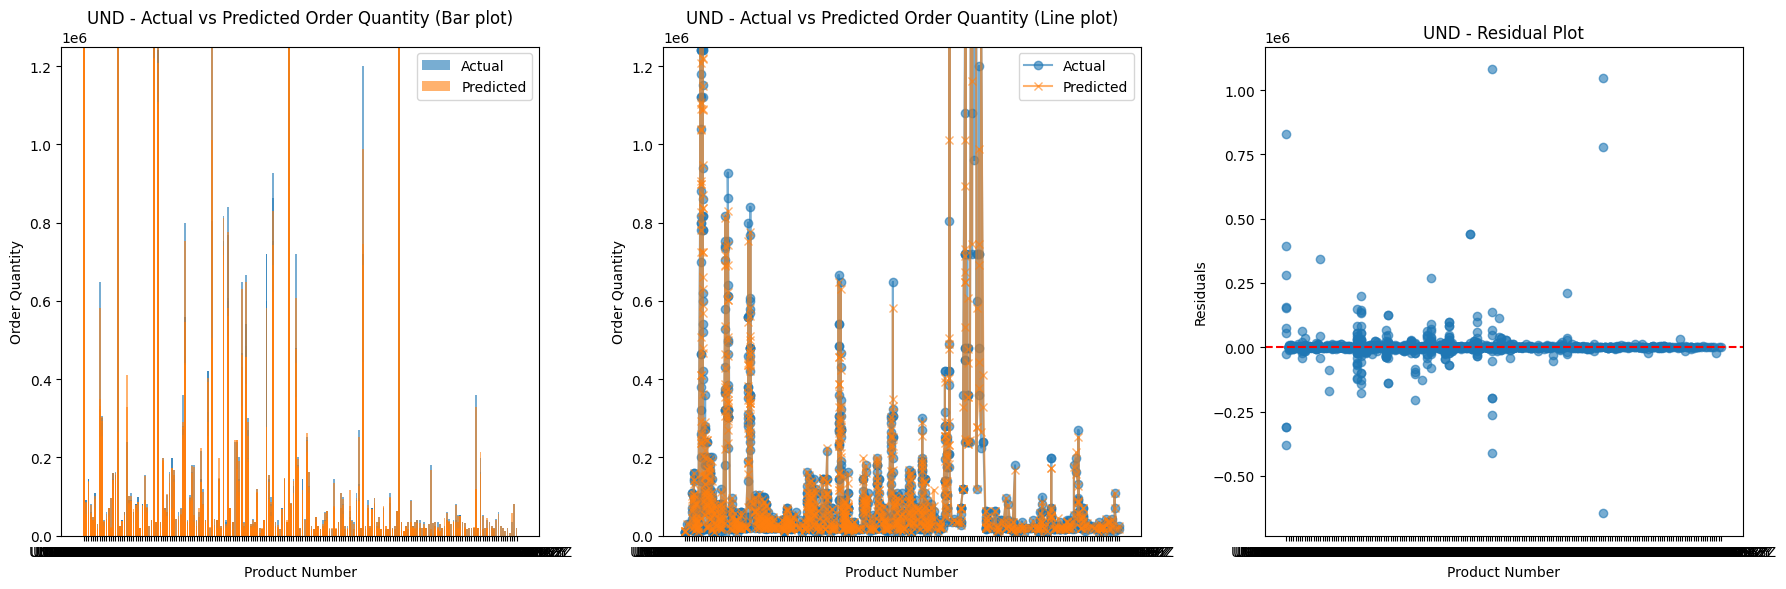

In [41]:
# Convert order year and month to datetime format
top_prods_df['OrderDate'] = pd.to_datetime(top_prods_df[['order_year', 'order_month']].astype(str).agg('-'.join, axis=1))

# Sort by OrderDate to maintain time order
top_prods_df = top_prods_df.sort_values(by='OrderDate')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Bar plot, actual and predicted values over time
axes[0].bar(df.loc[y_val.index, 'ProductNumber'], y_val, label='Actual', alpha=0.6)
axes[0].bar(df.loc[y_val.index, 'ProductNumber'], y_pred_rf, label='Predicted', alpha=0.6)
axes[0].set_xlabel('Product Number')
axes[0].set_ylabel('Order Quantity')
axes[0].set_title(f'{custom_ref} - Actual vs Predicted Order Quantity (Bar plot)')
axes[0].set_ylim(0, 1250000)
axes[0].legend()

# Line plot, actual and predicted values
sorted_indices = df.loc[y_val.index, 'ProductNumber'].argsort()
sorted_products = df.loc[y_val.index, 'ProductNumber'].iloc[sorted_indices]
sorted_actual = y_val.iloc[sorted_indices]
sorted_predicted = y_pred_rf[sorted_indices]

axes[1].plot(sorted_products, sorted_actual, label='Actual', alpha=0.6, marker='o')
axes[1].plot(sorted_products, sorted_predicted, label='Predicted', alpha=0.6, marker='x')
axes[1].set_xlabel('Product Number')
axes[1].set_ylabel('Order Quantity')
axes[1].set_title(f'{custom_ref} - Actual vs Predicted Order Quantity (Line plot)')
axes[1].set_ylim(0, 1250000)
axes[1].legend()

# Residual plot
residuals = y_val - y_pred_rf
axes[2].scatter(df.loc[y_val.index, 'ProductNumber'], residuals, alpha=0.6)
axes[2].axhline(y=0, color='r', linestyle='--')
axes[2].set_xlabel('Product Number')
axes[2].set_ylabel('Residuals')
axes[2].set_title(f'{custom_ref} - Residual Plot')

plt.tight_layout()
plt.show()


In [42]:
# Convert order year and month to datetime format
customer_total['OrderDate'] = pd.to_datetime(customer_total[['order_year', 'order_month']].astype(str).agg('-'.join, axis=1))

# Sort by OrderDate to maintain time order
customer_total = customer_total.sort_values(by='OrderDate')

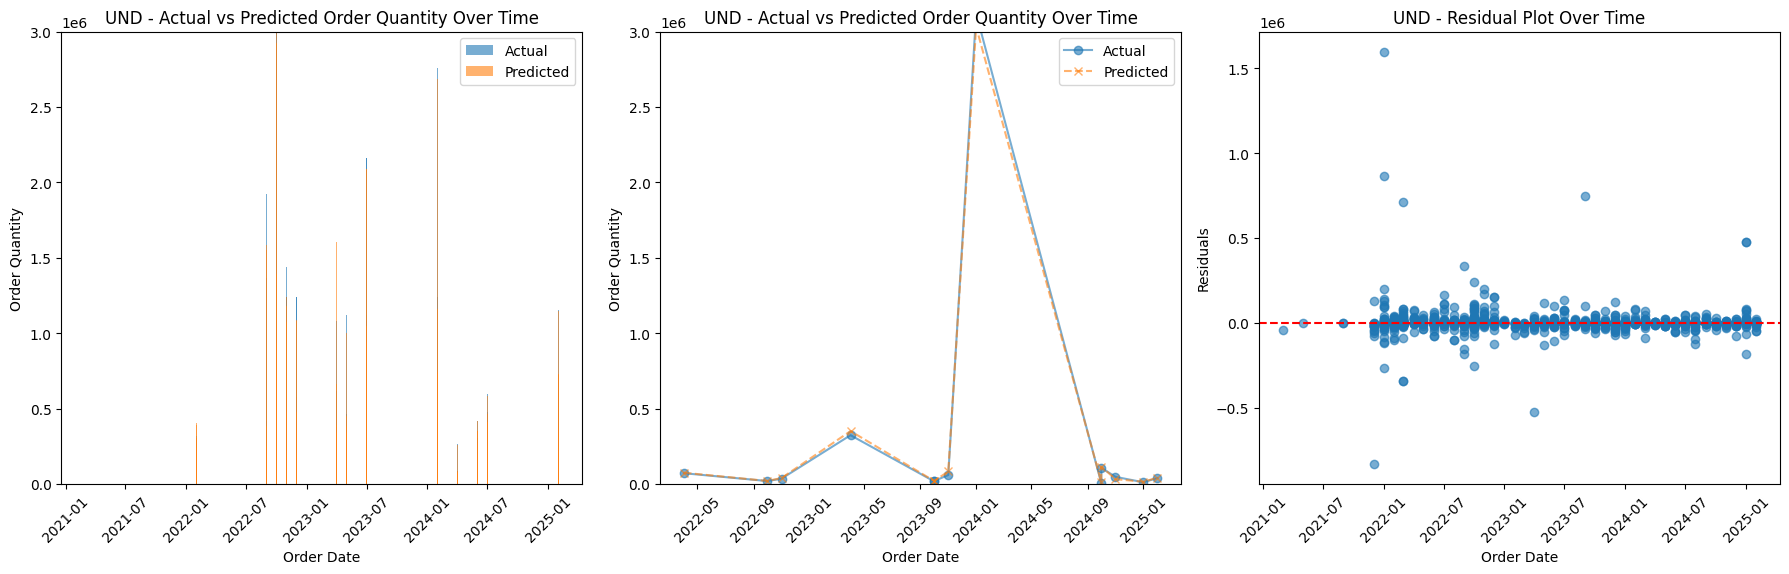

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Bar plot, actual and predicted values over time
axes[0].bar(customer_total.loc[total_y_val.index, 'OrderDate'], total_y_val, label='Actual', alpha=0.6)
axes[0].bar(customer_total.loc[total_y_val.index, 'OrderDate'], total_y_pred_rf, label='Predicted', alpha=0.6)
axes[0].set_xlabel('Order Date')
axes[0].set_ylabel('Order Quantity')
axes[0].set_title(f'{custom_ref} - Actual vs Predicted Order Quantity Over Time')
axes[0].set_ylim(0, 3000000)
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

# Line plot, actual and predicted values over time
sorted_indices = top_prods_df.loc[tp_y_val.index, 'OrderDate'].argsort()
sorted_dates = top_prods_df.loc[tp_y_val.index, 'OrderDate'].iloc[sorted_indices]
sorted_actual = total_y_val.iloc[sorted_indices]
sorted_predicted = total_y_pred_rf[sorted_indices]

axes[1].plot(sorted_dates, sorted_actual, label='Actual', alpha=0.6, marker='o', linestyle='-')
axes[1].plot(sorted_dates, sorted_predicted, label='Predicted', alpha=0.6, marker='x', linestyle='--')
axes[1].set_xlabel('Order Date')
axes[1].set_ylabel('Order Quantity')
axes[1].set_title(f'{custom_ref} - Actual vs Predicted Order Quantity Over Time')
axes[1].set_ylim(0, 3000000)
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

# Residual plot over time
residuals = total_y_val - total_y_pred_rf
axes[2].scatter(customer_total.loc[total_y_val.index, 'OrderDate'], residuals, alpha=0.6)
axes[2].axhline(y=0, color='r', linestyle='--')
axes[2].set_xlabel('Order Date')
axes[2].set_ylabel('Residuals')
axes[2].set_title(f'{custom_ref} - Residual Plot Over Time')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [44]:
# # to see dataframe structure
# customer_total.head()


In [45]:
# # to see prediction nparray structure
# total_y_pred_rf

In [46]:
# # Group data by OrderDate and sum the relevant numerical columns
# customer_total = top_prods_df.groupby('OrderDate').sum(numeric_only=True).reset_index()

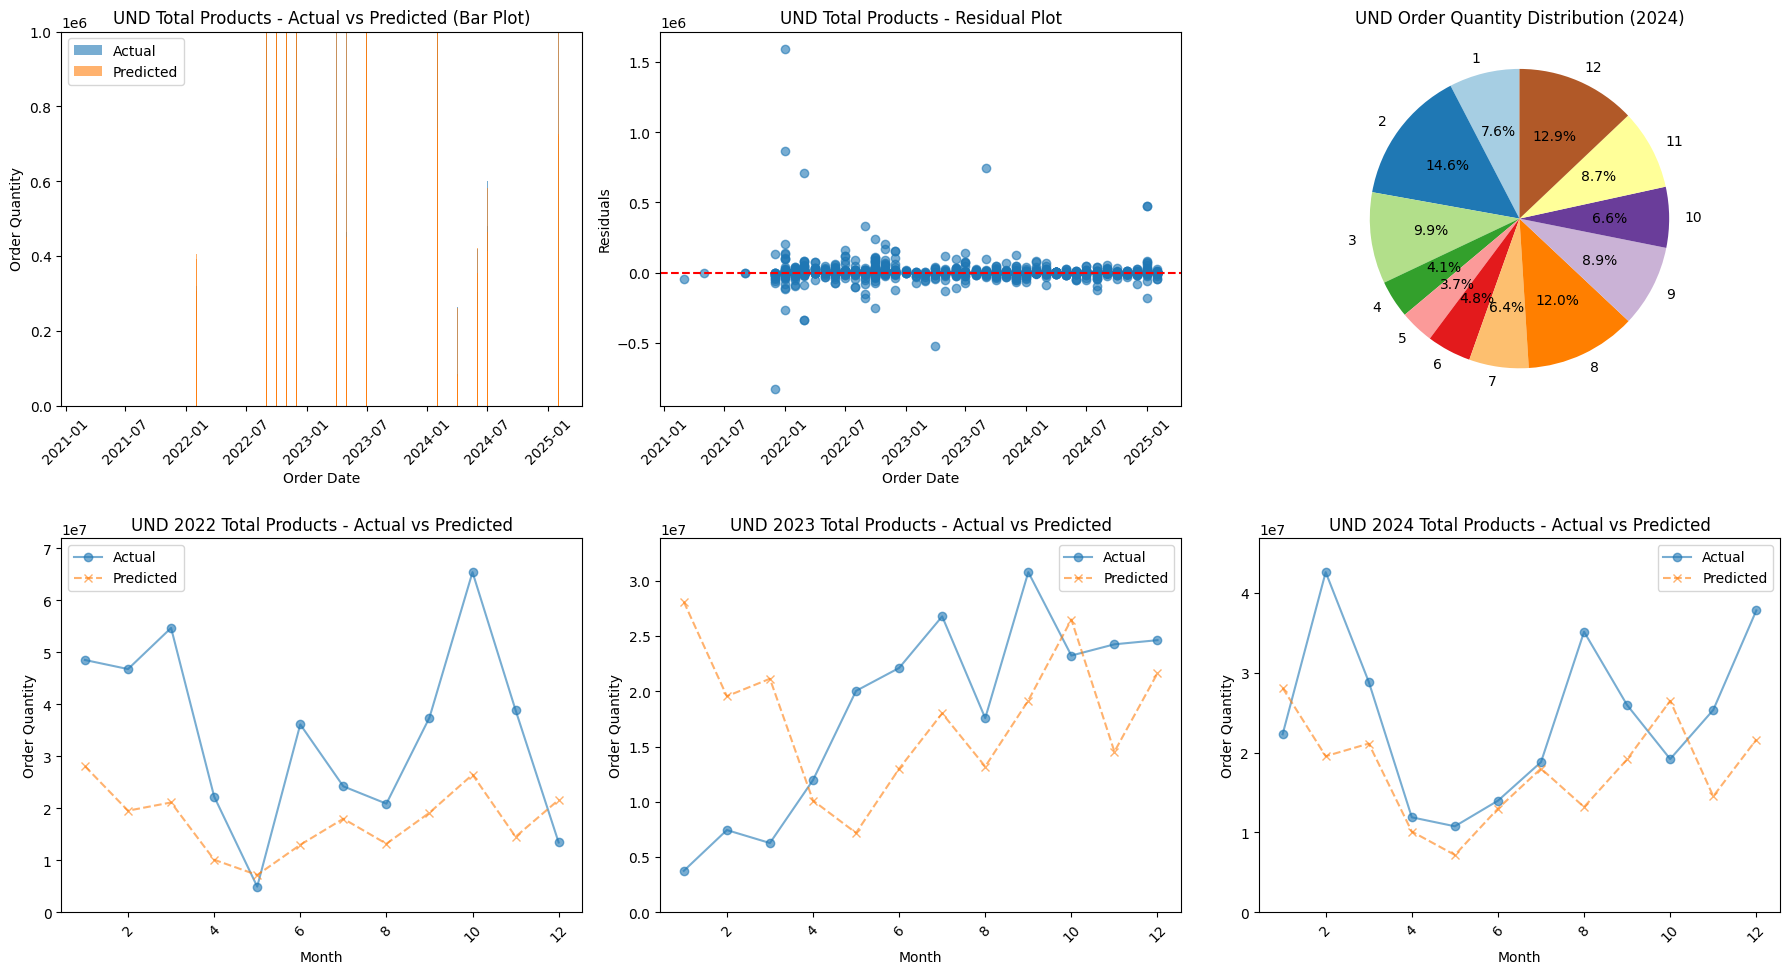

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust layout for better spacing

# Bar plot: Actual vs. Predicted Order Quantity
axes[0, 0].bar(customer_total.loc[total_y_val.index, 'OrderDate'], total_y_val, label='Actual', alpha=0.6)
axes[0, 0].bar(customer_total.loc[total_y_val.index, 'OrderDate'], total_y_pred_rf, label='Predicted', alpha=0.6)
axes[0, 0].set_xlabel('Order Date')
axes[0, 0].set_ylabel('Order Quantity')
axes[0, 0].set_title(f'{custom_ref} Total Products - Actual vs Predicted (Bar Plot)')
axes[0, 0].set_ylim(0, 1_000_000)
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# Residual Plot
residuals = total_y_val - total_y_pred_rf
axes[0, 1].scatter(customer_total.loc[total_y_val.index, 'OrderDate'], residuals, alpha=0.6)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Order Date')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title(f'{custom_ref} Total Products - Residual Plot')
axes[0, 1].tick_params(axis='x', rotation=45)

# Pie Chart: Order Quantity per Month (2024)
order_2024 = customer_total[customer_total['order_year'] == 2024].groupby('order_month')['OrderQuantity'].sum()
axes[0, 2].pie(order_2024, labels=order_2024.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
axes[0, 2].set_title(f'{custom_ref} Order Quantity Distribution (2024)')

# Line Plots: Yearly Trends
for i, year in enumerate([2022, 2023, 2024]):  
    yearly_df = customer_total[customer_total['order_year'] == year]

    if yearly_df.empty:
        continue  # skip if no data for that year

    # Aggregate OrderQuantity per month
    monthly_actual = yearly_df.groupby('order_month')['OrderQuantity'].sum()

    # Convert total_y_pred_rf to Pandas Series with index from customer_total
    pred_series = pd.Series(total_y_pred_rf, index=total_y_val.index)

    # Group predictions by month
    monthly_predicted = pred_series.groupby(customer_total.loc[total_y_val.index, 'order_month']).sum()

    # Sort for proper plotting
    monthly_actual = monthly_actual.sort_index()
    monthly_predicted = monthly_predicted.reindex(monthly_actual.index)  # Ensure same months

    # Plot actual and predicted values for the year
    axes[1, i].plot(monthly_actual.index, monthly_actual, label='Actual', alpha=0.6, marker='o', linestyle='-')
    axes[1, i].plot(monthly_predicted.index, monthly_predicted, label='Predicted', alpha=0.6, marker='x', linestyle='--')

    axes[1, i].set_xlabel('Month')
    axes[1, i].set_ylabel('Order Quantity')
    axes[1, i].set_title(f'{custom_ref} {year} Total Products - Actual vs Predicted')
    axes[1, i].set_ylim(0, max(monthly_actual.max(), monthly_predicted.max()) * 1.1)  # Scale Y axis
    axes[1, i].legend()
    axes[1, i].tick_params(axis='x', rotation=45)

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()


In [48]:
has_orders_2022 = not customer_total[customer_total['order_year'] == 2022].empty
print(f"Orders in 2022 exist: {has_orders_2022}")


Orders in 2022 exist: True


In [49]:
customer_total.head(10)

,ProductNumber,order_year,order_month,order_week,order_weekday,is_weekend,Customer_Num,OrderQuantity,prev_month_sales,prev_week_sales,...,moving_avg_6m,moving_avg_12m,moving_avg_18m,sales_2022,sales_2023,sales_2024,growth_2023,growth_2024,PhysicalInv,OrderDate
3696,UND-026-0086Z,2021,3,9,0,0,194.0,144000,72000.0,72000.0,...,132000.000000,99000.000000,132666.666667,0,0,0,NaN,NaN,144000,2021-03-01
3737,UND-026-0086Z,2021,3,9,0,0,194.0,144000,72000.0,72000.0,...,132000.000000,99000.000000,132666.666667,0,0,0,NaN,NaN,144000,2021-03-01
5302,UND-026-0114Z,2021,3,9,2,0,194.0,36000,40000.0,40000.0,...,35333.333333,26000.000000,24470.588235,0,0,0,NaN,NaN,0,2021-03-01
5027,UND-026-0107Z,2021,3,9,0,0,194.0,36000,168000.0,168000.0,...,193000.000000,159000.000000,138000.000000,0,0,0,NaN,NaN,18000,2021-03-01
4986,UND-026-0107Z,2021,3,9,0,0,194.0,36000,168000.0,168000.0,...,193000.000000,159000.000000,138000.000000,0,0,0,NaN,NaN,18000,2021-03-01
5286,UND-026-0114Z,2021,3,9,2,0,194.0,36000,40000.0,40000.0,...,35333.333333,26000.000000,24470.588235,0,0,0,NaN,NaN,0,2021-03-01
6143,UND-026-0151Z,2021,5,20,2,0,194.0,180000,18000.0,18000.0,...,72000.000000,45818.181818,45818.181818,0,0,0,NaN,NaN,0,2021-05-01
6056,UND-026-0147Z,2021,5,20,2,0,194.0,20000,20000.0,20000.0,...,20000.000000,33000.000000,32000.000000,0,0,0,NaN,NaN,0,2021-05-01
5576,UND-026-0124Z,2021,5,20,4,0,194.0,28000,28000.0,28000.0,...,29750.000000,29750.000000,29750.000000,0,0,0,NaN,NaN,0,2021-05-01
6069,UND-026-0147Z,2021,5,20,2,0,194.0,20000,20000.0,20000.0,...,20000.000000,33000.000000,32000.000000,0,0,0,NaN,NaN,0,2021-05-01


In [50]:
# from powerbiclient import QuickVisualize, get_dataset_config, Report
# from powerbiclient.authentication import InteractiveLoginAuthentication, DeviceCodeLoginAuthentication
# import pandas as pd

# prod_sales = pd.read_csv(
#     '/Users/mwilko777/Desktop/Project/Software Artifact/datasets/stock_forecasting/final/product_sales.csv')

# # use DeviceCodeLoginAuthentication if want to sign in each time, else InteractiveLoginAuthentication
# auth = InteractiveLoginAuthentication()
# print("Authentication successful.")


# def visual():
#     dataset_config = get_dataset_config(prod_sales)
#     return QuickVisualize(dataset_config, auth)

# visual()

In [51]:
customer_total.head()

,ProductNumber,order_year,order_month,order_week,order_weekday,is_weekend,Customer_Num,OrderQuantity,prev_month_sales,prev_week_sales,...,moving_avg_6m,moving_avg_12m,moving_avg_18m,sales_2022,sales_2023,sales_2024,growth_2023,growth_2024,PhysicalInv,OrderDate
3696,UND-026-0086Z,2021,3,9,0,0,194.0,144000,72000.0,72000.0,...,132000.000000,99000.0,132666.666667,0,0,0,NaN,NaN,144000,2021-03-01
3737,UND-026-0086Z,2021,3,9,0,0,194.0,144000,72000.0,72000.0,...,132000.000000,99000.0,132666.666667,0,0,0,NaN,NaN,144000,2021-03-01
5302,UND-026-0114Z,2021,3,9,2,0,194.0,36000,40000.0,40000.0,...,35333.333333,26000.0,24470.588235,0,0,0,NaN,NaN,0,2021-03-01
5027,UND-026-0107Z,2021,3,9,0,0,194.0,36000,168000.0,168000.0,...,193000.000000,159000.0,138000.000000,0,0,0,NaN,NaN,18000,2021-03-01
4986,UND-026-0107Z,2021,3,9,0,0,194.0,36000,168000.0,168000.0,...,193000.000000,159000.0,138000.000000,0,0,0,NaN,NaN,18000,2021-03-01


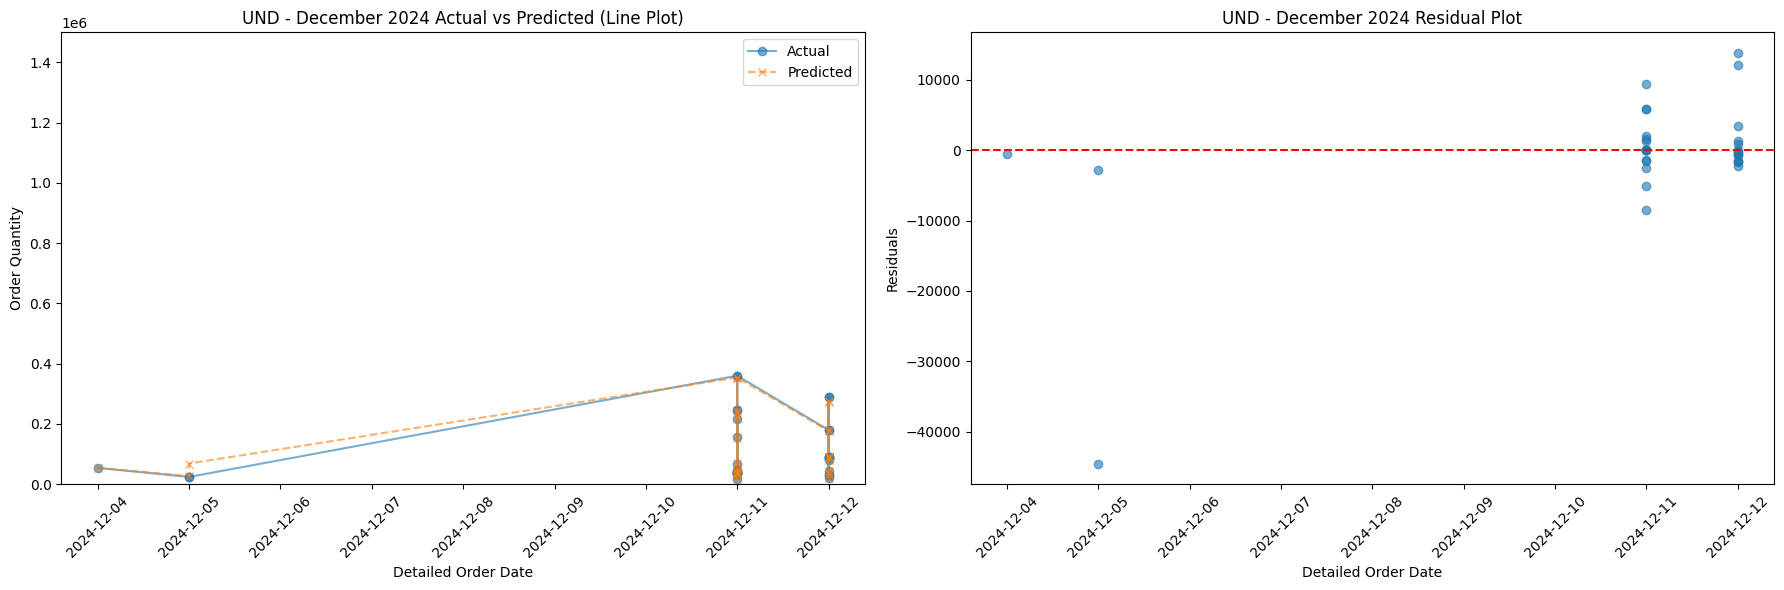

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create a DetailedOrderDate column using week and weekday information.
# Adjust the format as needed based on your data.
customer_total['DetailedOrderDate'] = pd.to_datetime(
    customer_total['order_year'].astype(str) +
    customer_total['order_week'].astype(str).str.zfill(2) +
    customer_total['order_weekday'].astype(str),
    format='%Y%W%w'
)

# Filter the data for December 2024 using DetailedOrderDate
dec_2024_data = customer_total[
    (customer_total['DetailedOrderDate'].dt.year == 2024) &
    (customer_total['DetailedOrderDate'].dt.month == 12)
]

# Use only the common indices between dec_2024_data and y_val
common_index = dec_2024_data.index.intersection(y_val.index)
dec_2024_actual = y_val.loc[common_index]
# Convert y_pred_rf to a Series for indexing (using the same index as y_val)
y_pred_rf_series = pd.Series(y_pred_rf, index=y_val.index)
dec_2024_predicted = y_pred_rf_series.loc[common_index]

# --- Incorporate your provided sorting snippet, adapted for December 2024 data ---
# Here we sort by DetailedOrderDate from dec_2024_data for the common indices.
sorted_indices = dec_2024_data.loc[common_index, 'DetailedOrderDate'].argsort()
sorted_dates = dec_2024_data.loc[common_index, 'DetailedOrderDate'].iloc[sorted_indices]
sorted_actual = dec_2024_actual.iloc[sorted_indices]
sorted_predicted = dec_2024_predicted.iloc[sorted_indices]
# --- End of sorting snippet ---

# Create subplots (1 row, 2 columns: one for line plot, one for residual plot)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Line Plot: Actual vs. Predicted Order Quantity using DetailedOrderDate
axes[0].plot(sorted_dates, sorted_actual, label='Actual', alpha=0.6, marker='o', linestyle='-')
axes[0].plot(sorted_dates, sorted_predicted, label='Predicted', alpha=0.6, marker='x', linestyle='--')
axes[0].set_xlabel('Detailed Order Date')
axes[0].set_ylabel('Order Quantity')
axes[0].set_title(f'{custom_ref} - December 2024 Actual vs Predicted (Line Plot)')
axes[0].set_ylim(0, 1_500_000)
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Residual Plot for December 2024
residuals_dec_2024 = sorted_actual - sorted_predicted
axes[1].scatter(sorted_dates, residuals_dec_2024, alpha=0.6)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Detailed Order Date')
axes[1].set_ylabel('Residuals')
axes[1].set_title(f'{custom_ref} - December 2024 Residual Plot')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [53]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
label_encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le  # Store encoder for inverse transformation if needed

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)


C:\Users\44777\AppData\Local\Temp\ipykernel_15232\4258343104.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])


In [54]:
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
metrics = {}

### Random Forest ###
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

print('\n' + '='*30 + ' RANDOM FOREST ' + '='*30)
evaluate_model(rf_model, X_train, y_train, 'TRAINING')
test_metrics = evaluate_model(rf_model, X_test, y_test, 'TEST')
metrics['Random Forest'] = test_metrics

### XGBoost ###
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid = {
    'n_estimators': [100, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
}
grid_xgb = GridSearchCV(xgb_model, param_grid, cv=3, 
                      scoring='neg_mean_absolute_error', n_jobs=-1)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_

print('\n' + '='*30 + ' XGBOOST ' + '='*30)
evaluate_model(best_xgb, X_train, y_train, 'TRAINING')
test_metrics = evaluate_model(best_xgb, X_test, y_test, 'TEST')
metrics['XGBoost'] = test_metrics

### Neural Network ###
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp = MLPRegressor(hidden_layer_sizes=(128, 64), learning_rate_init=0.01,
                 max_iter=1000, early_stopping=True, random_state=42)
mlp.fit(X_train_scaled, y_train)

print('\n' + '='*30 + ' NEURAL NETWORK ' + '='*30)
evaluate_model(mlp, X_train_scaled, y_train, 'TRAINING')
test_metrics = evaluate_model(mlp, X_test_scaled, y_test, 'TEST')
metrics['Neural Network'] = test_metrics

# Convert metrics to DataFrame
metrics_df = pd.DataFrame({k: v for k, v in metrics.items()}).T
metrics_df = metrics_df[['MAE', 'MSE', 'RMSE', 'R²']]
print('\nFINAL METRICS SUMMARY:')
print(metrics_df)


============================== RANDOM FOREST ==============================

TRAINING PERFORMANCE:
MAE: 5855.3463
MSE: 1128138007.6211
RMSE: 33587.7657
R²: 0.9891
---------------------------------------------

TEST PERFORMANCE:
MAE: 13732.4935
MSE: 3594192613.5610
RMSE: 59951.5856
R²: 0.9761
---------------------------------------------

============================== XGBOOST ==============================

TRAINING PERFORMANCE:
MAE: 1986.5011
MSE: 9892527.0000
RMSE: 3145.2388
R²: 0.9999
---------------------------------------------

TEST PERFORMANCE:
MAE: 5186.4341
MSE: 304296576.0000
RMSE: 17444.0986
R²: 0.9980
---------------------------------------------

============================== NEURAL NETWORK ==============================

TRAINING PERFORMANCE:
MAE: 61649.6976
MSE: 28856468111.3750
RMSE: 169871.9168
R²: 0.7223
---------------------------------------------

TEST PERFORMANCE:
MAE: 64521.1055
MSE: 33467046781.8987
RMSE: 182940.0087
R²: 0.7775
--------------------------------

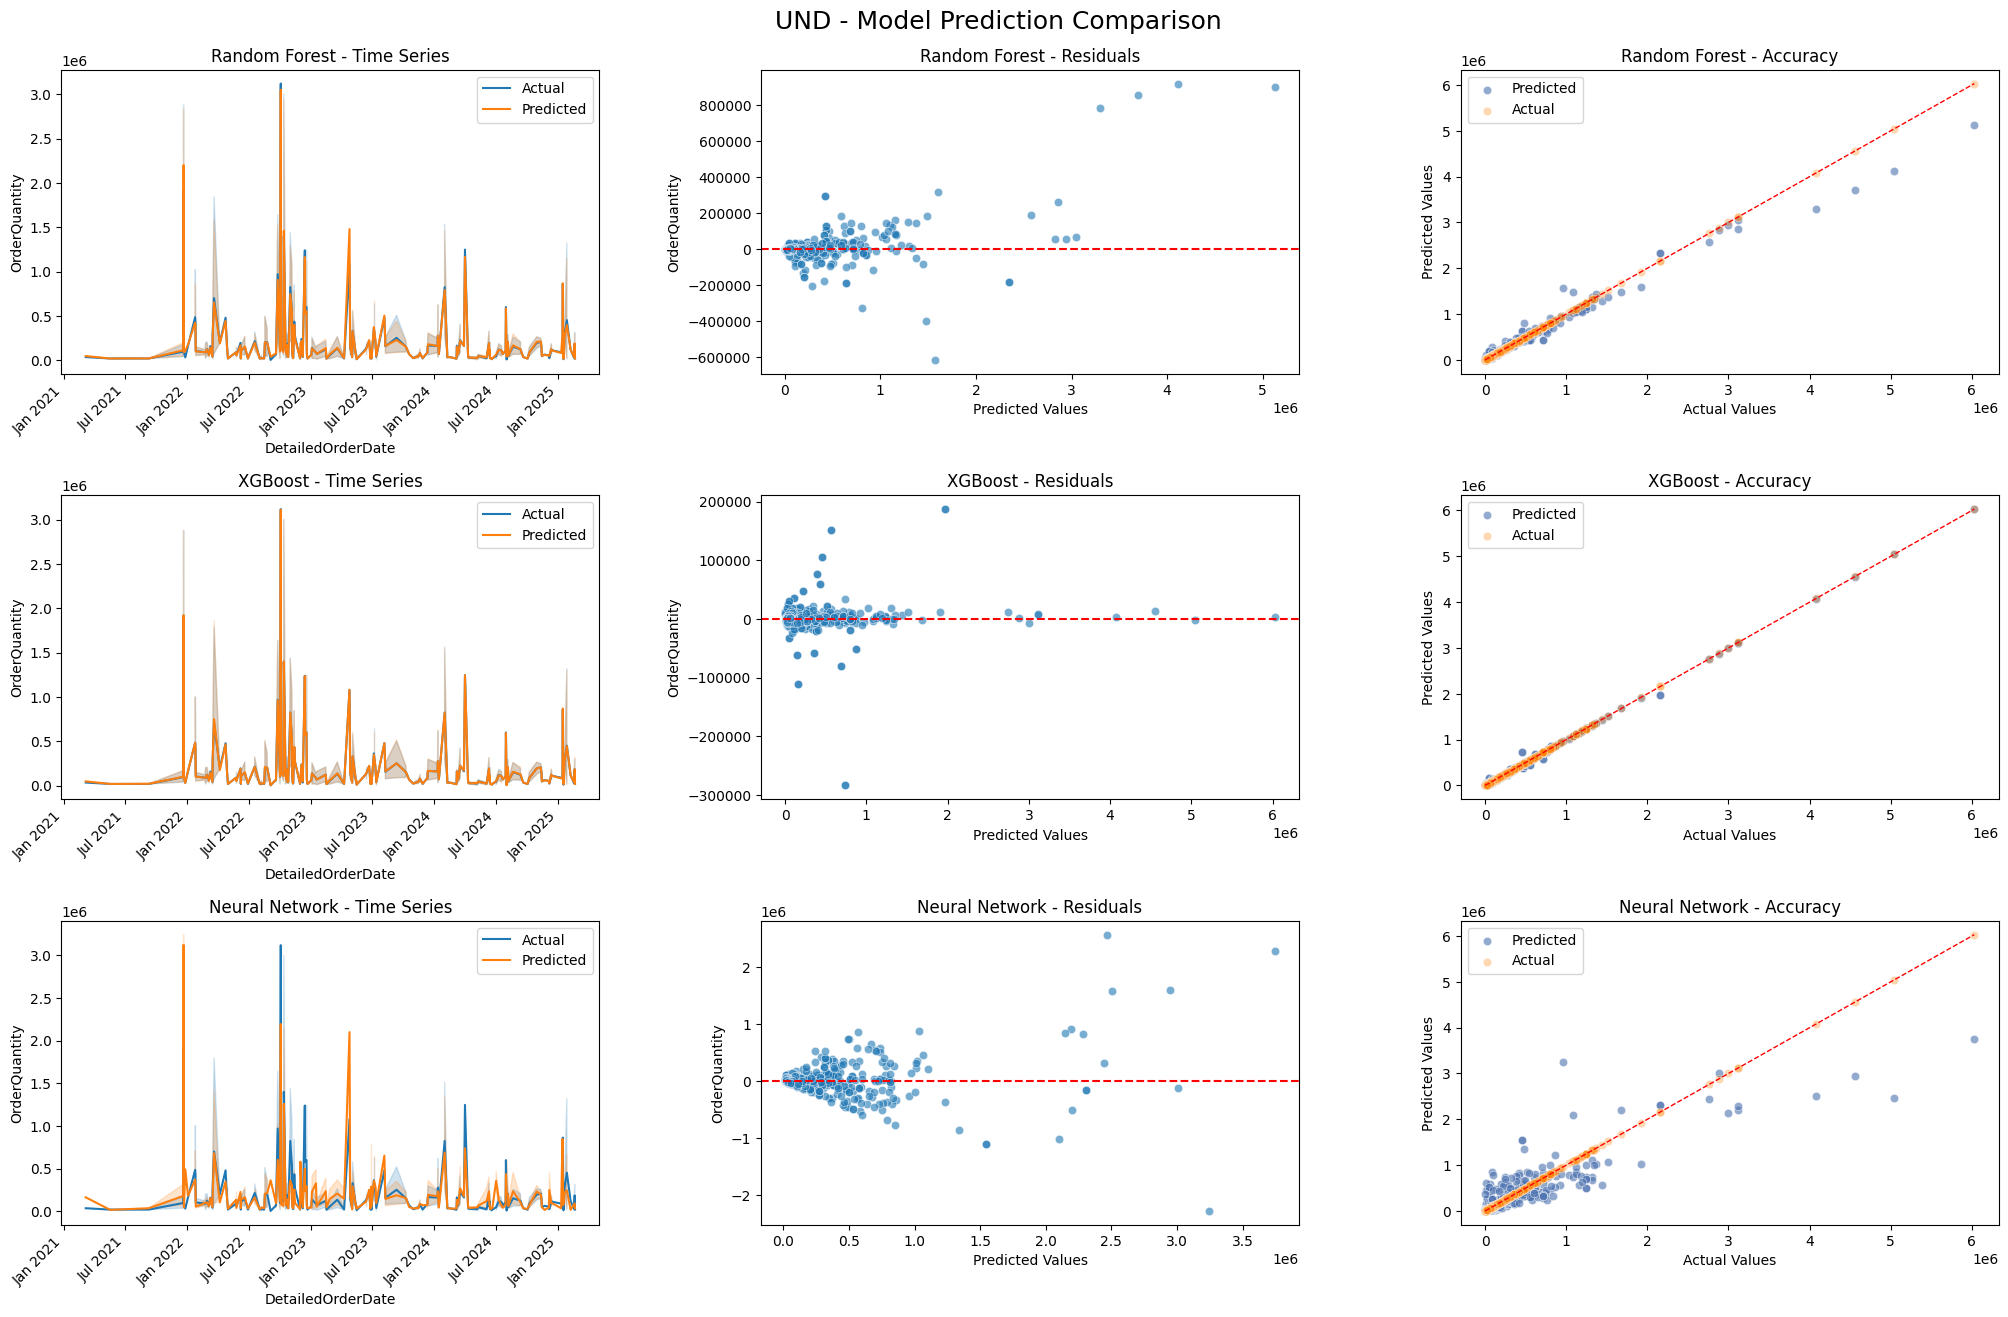

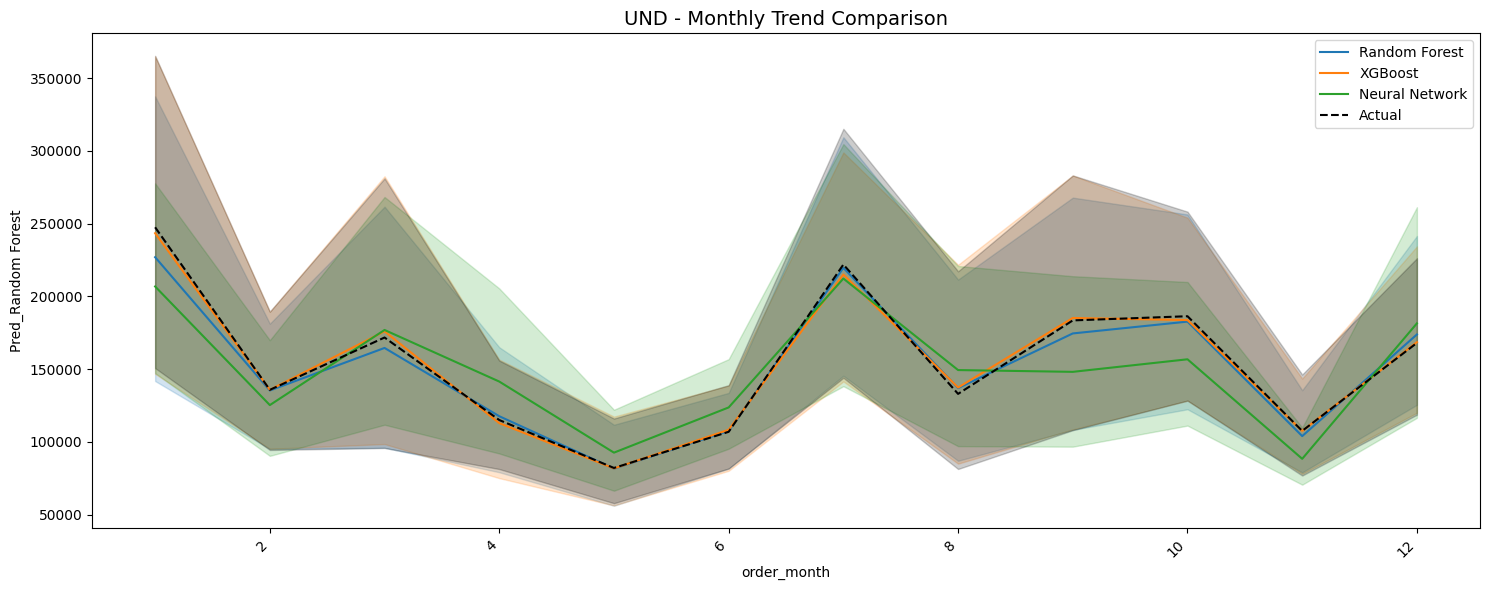

In [55]:
# Plotting code fix
import matplotlib.dates as mdates
import seaborn as sns

plot_dates = customer_total.loc[y_test.index, 'DetailedOrderDate']  # Changed X to df
if not pd.api.types.is_datetime64_any_dtype(plot_dates):
    plot_dates = pd.to_datetime(plot_dates)

# Create main comparison plots
fig, axes = plt.subplots(3, 3, figsize=(25, 15))
fig.suptitle(f"{custom_ref} - Model Prediction Comparison", 
             fontsize=18, y=0.92)
fig.subplots_adjust(hspace=0.4, wspace=0.3)

models = {
    "Random Forest": rf_model.predict(X_test),
    "XGBoost": best_xgb.predict(X_test),
    "Neural Network": mlp.predict(X_test_scaled)
}

for row, (model_name, y_pred) in enumerate(models.items()):
    # Time Series Comparison
    ax = axes[row, 0]
    sns.lineplot(x=plot_dates, y=y_test, label='Actual', ax=ax)
    sns.lineplot(x=plot_dates, y=y_pred, label='Predicted', ax=ax)
    ax.set_title(f'{model_name} - Time Series', fontsize=12)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Residual Plot
    ax = axes[row, 1]
    residuals = y_test - y_pred
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, ax=ax)
    ax.axhline(0, color='r', linestyle='--')
    ax.set_title(f'{model_name} - Residuals', fontsize=12)
    ax.set_xlabel('Predicted Values')
    
    # Actual vs Predicted
    ax = axes[row, 2]
    max_val = max(y_test.max(), y_pred.max())
    
    # Scatter plot with custom colors
    sns.scatterplot(x=y_test, y=y_pred, color='#4C72B0', alpha=0.6, ax=ax, label='Predicted')
    sns.scatterplot(x=y_test, y=y_test, color='#ff8000', alpha=0.3, ax=ax, label='Actual')  # Perfect line as reference
    
    # 1:1 reference line
    ax.plot([0, max_val], [0, max_val], 'r--', linewidth=1)
    
    ax.set_title(f'{model_name} - Accuracy', fontsize=12)
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.legend()

# Monthly trend plot fix
fig2, ax2 = plt.subplots(figsize=(15, 6))
monthly_data = df.loc[y_test.index, ['order_month']].copy()  # Changed X to df
monthly_data['Actual'] = y_test.values

for model_name, y_pred in models.items():
    monthly_data[f'Pred_{model_name}'] = y_pred
    sns.lineplot(x='order_month', y=f'Pred_{model_name}', 
                data=monthly_data, label=model_name, ax=ax2)

sns.lineplot(x='order_month', y='Actual', data=monthly_data, 
            label='Actual', ax=ax2, color='black', linestyle='--')
ax2.set_title(f'{custom_ref} - Monthly Trend Comparison', fontsize=14)
# ax2.xaxis.set_major_locator(mdates.MonthLocator())
# ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()